# Feature selection&Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import xgboost as xgb
import seaborn as sns
import datetime as dt

%matplotlib inline

store_info = pd.read_csv('store_info_1.csv')
training = pd.read_csv('training_1.csv')
testing = pd.read_csv('testing_1.csv')
weather= pd.read_csv('weather_all_1.csv')

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Change columns type

In [39]:
for i in ['Baden-Wuerttemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hesse', 'Lower Saxony', 'Mecklenburg Western Pomerania','Northrhine-Westphalia','Rhineland Palatinate','Saarland','Saxony','Saxony-Anhalt','Schleswig Holstein','Thuringia','day_to_holiday','day_from_holiday']:
    training[i]= training[i].astype(int)
    testing[i]= testing[i].astype(int)

## Anomaly detection

I use every day Sale-Cust rate as detection metric. 

In [40]:
import pylab as py

In [41]:
training['Sale_Customer_Rate'] = training.Sales/(training.Customers)

I decide to fillna by 0 because numerator-Customer can be zero and that means the store was closed.

In [42]:
training.Sale_Customer_Rate.fillna(0,inplace=True)

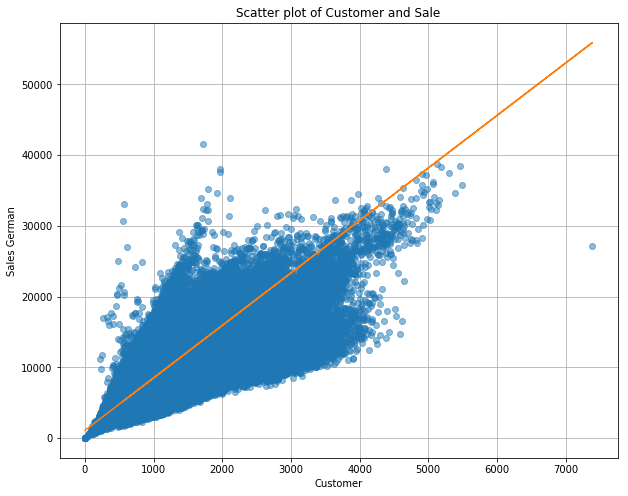

In [43]:
# Original scatter plot with x customer y sales
x= training.Customers
y= training.Sales
plt.figure(figsize=(10,8))
py.plot(x,y,'o',alpha=.5)
z = np.polyfit(x,y,1)
p = np.poly1d(z)
py.plot(x,p(x))
plt.xlabel('Customer')
plt.ylabel("Sales German")
plt.title('Scatter plot of Customer and Sale')
plt.grid(True);

Because the sale_cust will be zero when day-off so I decide to exclue data that stores are close.

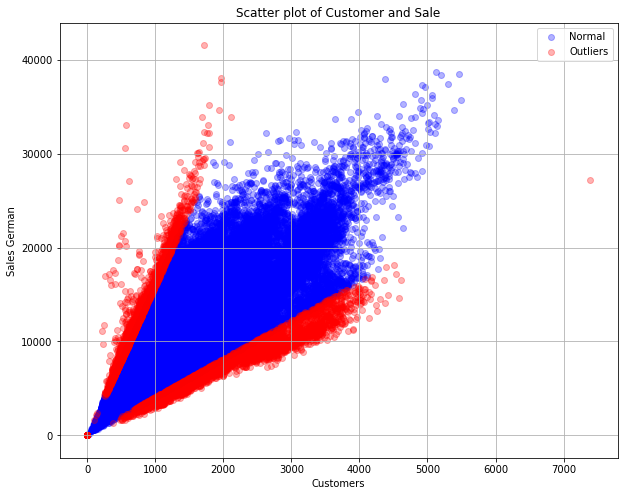

In [44]:
open_data= training[training.Open==1]
upper_bound= np.percentile(open_data.Sale_Customer_Rate,99.5)
lower_bound= np.percentile(open_data.Sale_Customer_Rate,0.5)

anomal_data = open_data[(open_data.Sale_Customer_Rate>=upper_bound)|(open_data.Sale_Customer_Rate<=lower_bound)]
normal_data= open_data[(open_data.Sale_Customer_Rate<upper_bound)&(open_data.Sale_Customer_Rate>lower_bound)]


plt.figure(figsize=(10,8))
plt.scatter(normal_data.Customers,normal_data.Sales, label= 'Normal',color= 'b',alpha= .3)
plt.scatter(anomal_data.Customers,anomal_data.Sales, label= 'Outliers',color= 'r', alpha= .3)
plt.legend()
plt.xlabel('Customers')
plt.ylabel("Sales German")
plt.title('Scatter plot of Customer and Sale')
plt.grid(True);

In [45]:
# Exclude outlier
outlier_id = anomal_data.index
training= training.drop(['Sale_Customer_Rate'],axis= 1)
training_1= training.drop(labels= outlier_id,axis=0).copy()

In [46]:
# Merge files
testing_1= testing.copy()
# First store_information
training_1= pd.merge(training_1,store_info,on='Store')
testing_1= pd.merge(testing_1,store_info,on='Store')

## Create validation sets

In [47]:
# I use the last 6 weeks as my validation sets
validation_set= training_1[(training_1.Year== 2015)&(training_1.Week>=25)&(training_1.Week<=31)]
validation_set.reset_index(inplace=True)
validation_set.drop('index',inplace=True,axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [48]:
training_set= training_1[~((training_1.Year== 2015)&(training_1.Week>=25)&(training_1.Week<=31))]
training_set.reset_index(inplace=True)
training_set.drop('index',inplace=True,axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Modeling

Here I decide to rely on boosting tree(XGBoost) completely as candidates and use default parameter Random forest as my baseline model

### Define evaluation metric

In [60]:

def RMSPE(y_pred,y_true):
    
    """Use this function to evaluate my model performance on validation set"""
    score= 0
    for index in range(len(y_true)):
        if y_true[index]==0:
            score+= 0 # Due to denominator cannot be zero.
        else:
            score+= ((y_pred[index]- y_true[index])/y_true[index])**2
    n= len(y_true)
    score= np.sqrt(score/n)
    return score

### Use boosting-tree  approach

In [55]:
# Default parameter
bst= xgb.XGBRegressor(seed=0)
bst.fit(x_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [56]:
training_y= bst.predict(x_train)
prediction= bst.predict(x_validation)

In [57]:
# Behavior on training set and validation set
print('Training set:',RMSPE(training_y,y_train))
print('Validation set:',RMSPE(prediction,y_validation))

Training set: 0.426343595064
Validation set: 0.365590911543


It looks like that I am facing underfitting problem.

To improve my result, I did a lttle search and found a [post](https://www.kaggle.com/c/rossmann-store-sales/discussion/17026#96290) from disscuion forum. So I decided to give it try (log transform).

But first, I have to remove zero values

In [58]:
training_set_non_0= training_set[training_set.Sales !=0]
validation_set_non_0= validation_set[validation_set.Sales != 0]
training_set_non_0.reset_index(inplace=True)
training_set_non_0.drop('index',inplace=True,axis=1)
validation_set_non_0.reset_index(inplace=True)
validation_set_non_0.drop('index',inplace=True,axis=1)


x_train= training_set_non_0.drop(['Date','Customers','Sales'],axis= 1)
y_train_log= np.log(training_set_non_0['Sales'])

x_validation= validation_set_non_0.drop(['Date','Customers','Sales'], axis=1)
y_validation_log= np.log(validation_set_non_0['Sales'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
bst= xgb.XGBRegressor(seed=0)
bst.fit(x_train,y_train_log)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [24]:
training_logy= bst.predict(x_train)
prediction_logy= bst.predict(x_validation)

In [25]:
# Behavior on training set and validation set
print('Training set:',RMSPE(np.exp(training_logy),np.exp(y_train_log)))
print('Validation set:',RMSPE(np.exp(prediction_logy),np.exp(y_validation_log)))

Training set: 0.400979091104
Validation set: 0.336244799831


It looks like both training and validation performance are little better but still facing underfitting.

To increase my accuracy, I decide to tune some critical parameters that can drastically affect the result of model.

In [87]:
bst= xgb.XGBRegressor(n_estimators=650,max_depth=10,seed=0,nthread=-1,learning_rate=0.2)
bst.fit(x_train_,y_train_log)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=650, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [90]:
training_logy= bst.predict(x_train)
prediction_logy= bst.predict(x_validation_log)

In [91]:
print('Training set:',RMSPE(np.exp(training_logy),np.exp(y_train_log)))
print('Validation set:',RMSPE(np.exp(prediction_logy),np.exp(y_validation_log)))

Training set: 0.0606407121867
Validation set: 0.119813854619


#### Tuning records

n_estimators=100,max_depth=6  0.224 on validation set

n_estimators=100,max_depth=10 0.19 on validation set

n_estimators=150,max_depth=10 0.13 on validaiton set 

n_estimators=150,max_depth=15  0.128 on validation set

n_estimators=200,max_depth=15, 0.12 on validation set

n_estimators=200,max_depth=8,learning_rate=0.03 0.24 on validation set

n_estimators=500,max_depth=8,learning_rate=0.03 0.17 on validation set

n_estimators=500,max_depth=8,learning_rate=0.25 0.117 on validation set

n_estimators=650,max_depth=10,learning_rate=0.2 0.119 on validation set

Here, I want to enjoy the "pain" of tuning parameters, so I manually tune 2 parameters several times and it looks I am on the right direction so far. Then I decide to predict on the test set and check the score. Then I notice that the marginal improvement is getting close to zero, so I decide to tune extra parameters.



In [96]:
x_test= testing_1.drop(['Date','Id'],axis=1)
y_test= bst.predict(x_test)

base_result.loc[:,'Sales']= np.exp(y_test).astype(int)
base_result.to_csv('result_1.csv',index=False)

Below is the best reslut I could approach by manual tuning(n_estimators=200,max_depth=15)

![result1.png](result1.png)

A slightly better than base model score, 0.159. And above validation results show that I am getting a better score each time but marginal improvement decrease.